In [78]:
# Plotting related
import os
import sys

sys.tracebacklimit = 0
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", None)
pd.options.mode.copy_on_write = True

import importlib

# Constants and functions for this project
import constants
from constants import *
import auxFunctions as af

import shutil
shutil.copy('constants.py', 'export/')
from IPython.display import display, HTML, Markdown

# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")

sys.tracebacklimit = 0
def exception_handler(exception_type, exception, traceback):
    # All your trace are belong to us!
    # your format
    print(f"{exception_type.__name__}, {exception}")

sys.excepthook = exception_handler

In [79]:
# Reset index to insure we iterate over them in the order of max_diff
basedir = "/home/yonatan/Documents/projects/vaccines/code"
pkl_path = os.path.join(basedir, f"pickles/results-max-diff{ROC_PRC_str}.pkl")
results = pd.read_pickle(pkl_path).reset_index()

In [80]:
%%script true
Plot all datasets with their max-difference metric
importlib.reload(af)
sorted_data = results.sort_values(dataset_col, ignore_index=True).reset_index()

sns.scatterplot(data=sorted_data, x=dataset_col, y="max_difference")
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.title(f"max(immage - age, immage & age - age)")
af.save_and_show_plot(f"figures/all-datasets-max-diff{ROC_PRC_str}.png")

In [81]:
%%script true
# This inactivates the cell


datasets, metadata = af.load_data()
age_str = f", subjects over the age of {age_threshlod}" if bOlderOnly else ""

# Run all datasets, each individually
importlib.reload(af)
importlib.reload(constants)

for index, row in results.iterrows():
    params = {
        "bAdjustMFC" : row["bAdjustMFC"],
        "dataset_name": row[dataset_col],
        "strain_index": row[strain_index_col],
        "day": row[day_col]
    }

    print("\n\n\n")
    text = f"Analysis for dataset: {row[dataset_col]}, strain: {row[strain_col]}, day: {row[day_col]}, using adjFC: {bAdjustMFC}"
    text = f"<div style='font-size:20px;font-weight:bold;'>{text}</div>"

    display(HTML(text))
    res = af.run_single_dataset(datasets, metadata, params)

    display(res)

Text(0.5, 1.0, 'max difference in score, IMMAGE, Age and Multivar')

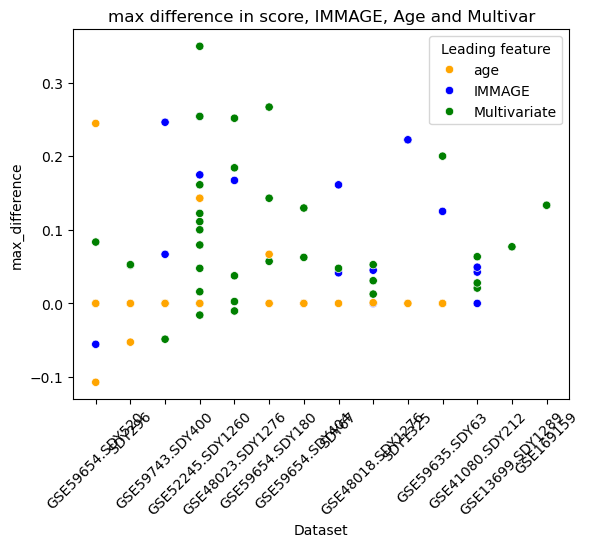

In [82]:
importlib.reload(af)
importlib.reload(constants)

# Plot by whether IMMAGE or combined IMMAGE & Age was better

def get_leading_feature(row):
    immage_age = row["Composite", "IMMAGE"] - row["Composite", "Age"]
    multivar_age = row["Composite", "Multivariate"] - row["Composite", "Age"]
    if max(immage_age, multivar_age) > 0:
        if immage_age > multivar_age:
            feature = "IMMAGE"
        else :
            feature = "Multivariate"
    else:
        feature = "age"
    return feature

palette = {"age": "orange", "IMMAGE": "blue", "Multivariate": "green"}
results["Leading feature"] = results.apply(lambda row: get_leading_feature(row), axis=1)
sorted_data = results.sort_values("max_difference", ignore_index=True).reset_index(drop=True)
scatter = sns.scatterplot(data=sorted_data, x=dataset_col, y="max_difference", hue="Leading feature", palette=palette)
# handles, labels = scatte.get_legend_handles_labels()
# fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.title(f"max difference in score, IMMAGE, Age and Multivar")

af.save_and_show_plot(f"figures/all-datasets-max-diff-by-leading-feature{ROC_PRC_str}.png")

(-1.0999988954043582, 1.099982507644154, -1.099985551197169, 1.099997136159728)

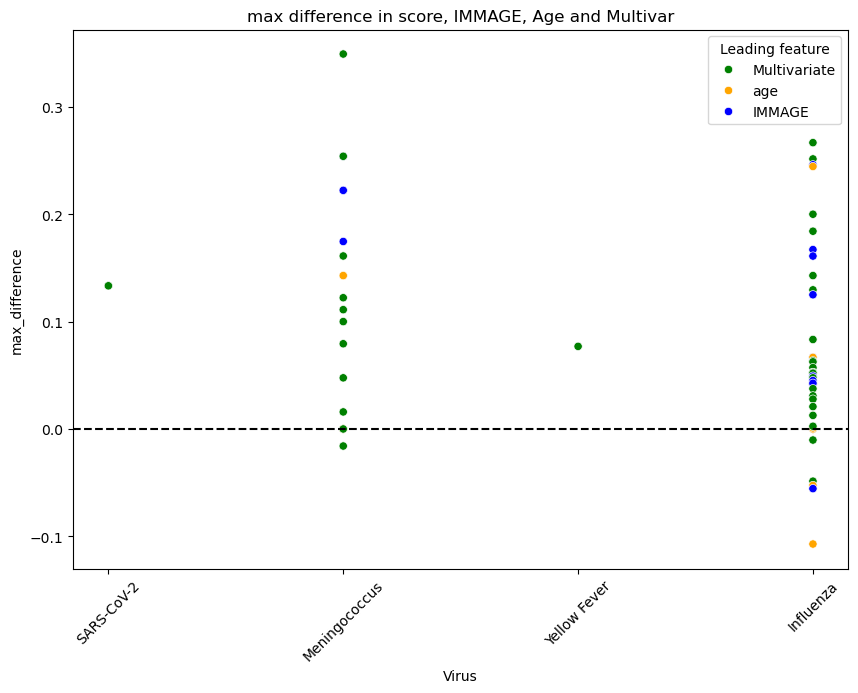

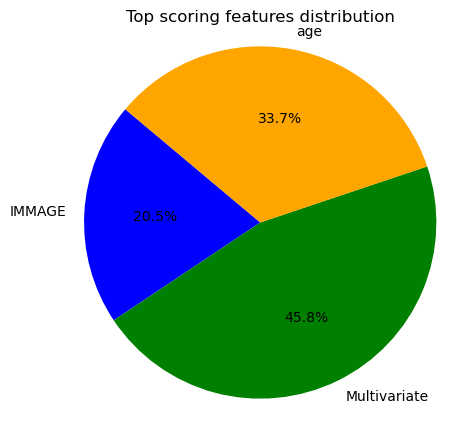

In [83]:
importlib.reload(af)
importlib.reload(constants)

# Plot by whether IMMAGE or combined IMMAGE & Age was better

def get_leading_feature(row):
    immage_age = row["Composite", "IMMAGE"] - row["Composite", "Age"]
    multivar_age = row["Composite", "Multivariate"] - row["Composite", "Age"]
    if max(immage_age, multivar_age) > 0:
        if immage_age > multivar_age:
            feature = "IMMAGE"
        else :
            feature = "Multivariate"
    else:
        feature = "age"
    return feature

palette = {"age": "orange", "IMMAGE": "blue", "Multivariate": "green"}
results["Leading feature"] = results.apply(lambda row: get_leading_feature(row), axis=1)
plt.figure(figsize=(10, 7))

grouped_data = results.groupby("Virus")['max_difference'].mean().reset_index()
grouped_data.columns = ["Virus", 'mean_max_diff']
grouped_data = pd.merge(results, grouped_data, on="Virus", how='left')

sorted_data = grouped_data

sorted_data["strain_idx_str"] = sorted_data[strain_index_col].astype(str)
sorted_data['disp'] = sorted_data["Virus"] + "(" + sorted_data["strain_idx_str"] + ")"
sorted_data = sorted_data.sort_values("mean_max_diff", ignore_index=True, ascending=False).reset_index(drop=True)
sorted_data.drop('index', axis=1, inplace=True)

scatter = sns.scatterplot(x=sorted_data["Virus"], y=sorted_data[ "max_difference" ], hue=sorted_data[ "Leading feature" ], palette=palette)
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
# plt.xticks(range(len(sorted_data)), sorted_data[vaccine_col], rotation=45)  # Adjust the rotation angle as needed

plt.axhline(y=0, color="black", linestyle="--")
plt.title(f"max difference in score, IMMAGE, Age and Multivar")
af.save_and_show_plot(f"figures/all-datasets-max-diff-by-leading-feature{ROC_PRC_str}.png")

# We see that immage mostly improves age, rather than outperforms it

# Plot a pie chart to show the relative quantities
disease_counts = results.groupby("Leading feature").index.count()
plt.figure(figsize=(5, 5))
plt.pie(disease_counts, labels=disease_counts.index, autopct='%1.1f%%', startangle=140, colors=[palette[i] for i in disease_counts.index])
plt.title('Top scoring features distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
af.save_and_show_plot(f"figures/all-datasets-max-diff-feature-distribution{ROC_PRC_str}.png")
plt.show()

disease_counts

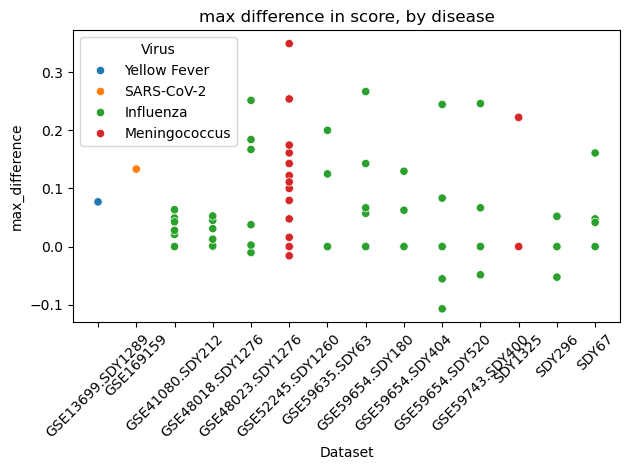

In [84]:
# Plot by whether the dataset is an Influenza one or not

def get_influenza_label(row):
    influenza_df = pd.DataFrame(influenza_dicts)
    influenza_datasets = influenza_df[dataset_col]
    label = "Influenza" if row[dataset_col] in influenza_datasets.values else "Other"
    # print(row[dataset_col])
    # print(row[dataset_col] in influenza_datasets)
    return label

results["Disease"] = results.apply(lambda row: get_influenza_label(row), axis=1)
sorted_data = results.sort_values(dataset_col, ignore_index=True).reset_index(drop=True)
scatter = sns.scatterplot(data=sorted_data, x=dataset_col, y="max_difference", hue="Virus")
# handles, labels = scatte.get_legend_handles_labels()
# fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.title(f"max difference in score, by disease")
af.save_and_show_plot(f"figures/all-datasets-max-diff-by-disease{ROC_PRC_str}.png")



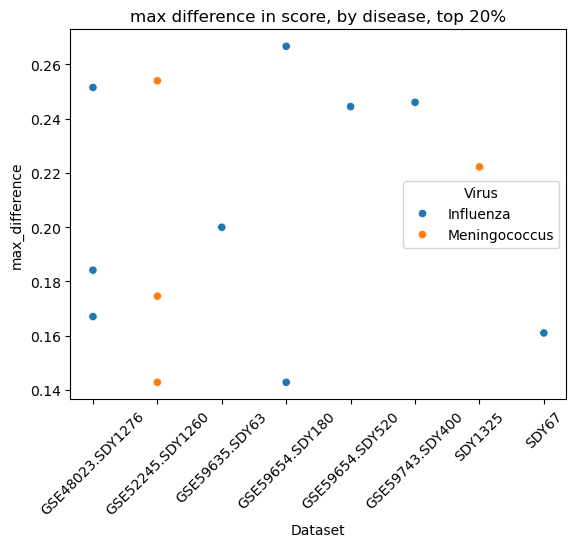

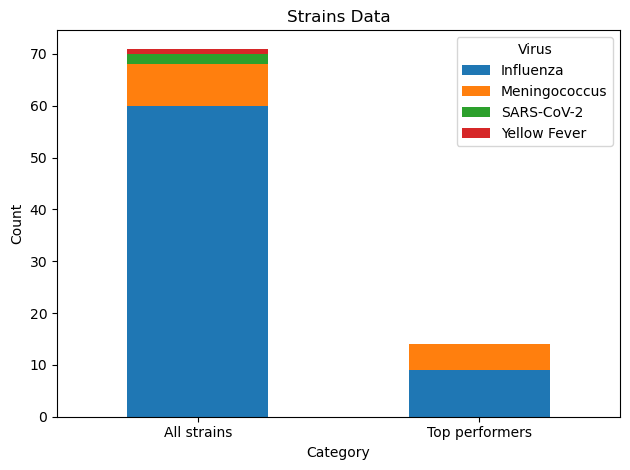

In [85]:
# Plot by whether the dataset is an Influenza one or not, taking only the top performers

def get_influenza_label(row):
    influenza_df = pd.DataFrame(influenza_dicts)
    influenza_datasets = influenza_df[dataset_col]
    label = "Influenza" if row[dataset_col] in influenza_datasets.values else "Other"
    # print(row[dataset_col])
    # print(row[dataset_col] in influenza_datasets)
    return label

results = pd.read_pickle(pkl_path).reset_index()
results = results[(results['Dataset'] != 'GSE52245.SDY1260') | (results['Strain'] == 'IgM_serotype_A') | (results['Strain'] == 'IgM_serotype_C')]
results["Disease"] = results.apply(lambda row: get_influenza_label(row), axis=1)

max_diff_threshold = results[["max_difference"]].quantile(q=0.8).item()
sorted_data = results.sort_values(dataset_col, ignore_index=True).reset_index(drop=True)
sorted_data = sorted_data.loc[sorted_data["max_difference"] > max_diff_threshold]

scatter = sns.scatterplot(data=sorted_data, x=dataset_col, y="max_difference", hue="Virus")
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.title(f"max difference in score, by disease, top 20%")

# af.save_and_show_plot(f"figures/all-datasets-max-diff-by-disease-top-performers{ROC_PRC_str}.png")


# Filter the data for Influenza and Other categories
grouped_data_filtered = sorted_data.groupby('Virus')[dataset_col].count().reset_index()
grouped_data_orig = results.groupby('Virus')[dataset_col].count().reset_index()
col_name_filtered = "Top performers"
col_name_orig = "All strains"
grouped_data_filtered = grouped_data_filtered.rename(columns={dataset_col: col_name_filtered})
grouped_data_orig = grouped_data_orig.rename(columns={dataset_col: col_name_orig})

combined_data = grouped_data_orig.merge(grouped_data_filtered, on='Virus', how='left')

# Melting the data, making it long-form for easier plotting
combined_data_melted = combined_data.melt(id_vars='Virus', var_name='Category', value_name='Count')

# Creating a sideways, stacked bar plot
combined_data_melted.pivot_table(index='Category', columns='Virus', values='Count')\
          .plot(kind='bar', stacked=True)

# Labeling the plot and showing it
plt.xticks(rotation=0)  # Adjust the rotation angle as needed
plt.title('Strains Data')
plt.ylabel('Count')
plt.xlabel('Category')
plt.legend(title='Virus')
# Save and show the plot
plt.tight_layout()
af.save_and_show_plot('figures/stacked-bar-comparison{ROC_PRC_str}.png')



Text(0.5, 1.0, 'max difference in score, IMMAGE, Age and Multivar')

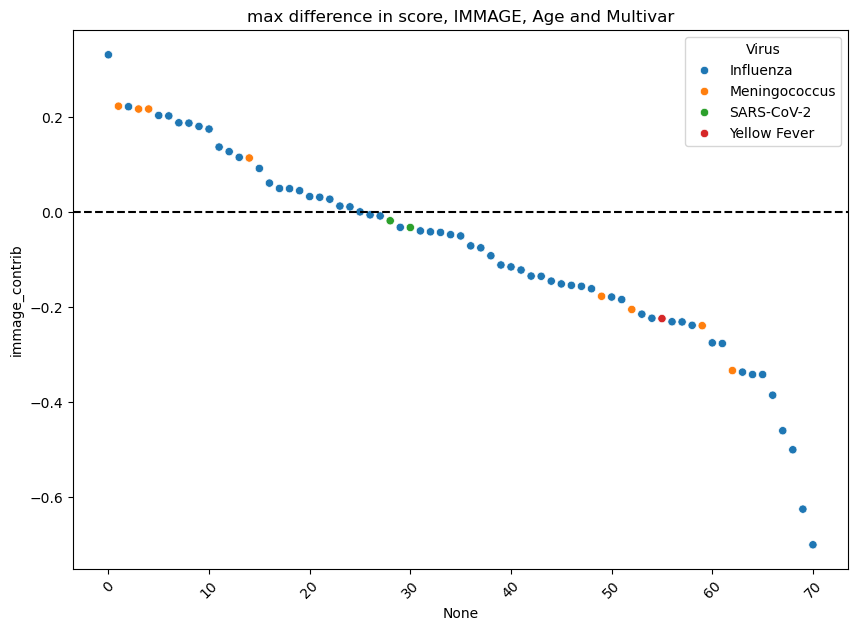

In [86]:
importlib.reload(af)
importlib.reload(constants)

# Plot by whether IMMAGE or combined IMMAGE & Age was better
results_filtered = results[(results['Dataset'] != 'GSE52245.SDY1260') | (results['Strain'] == 'IgM_serotype_A') | (results['Strain'] == 'IgM_serotype_C')]
results_filtered[results_filtered["Virus"].str.contains("Men", case=False)]
results = results_filtered
palette = {"age": "orange", "IMMAGE": "blue", "Multivariate": "green"}
results['immage_contrib'] = results["Composite", "IMMAGE"] - results["Composite", "Age"]
results['multivar_contrib'] = results["Composite", "Multivariate"] - results["Composite", "Age"]
plt.figure(figsize=(10, 7))

# For each row (=dataset,strain combination) add the mean score of the group(=virus) it belongs to
grouped_data = results.groupby("Virus")['immage_contrib'].mean().reset_index()
grouped_data.columns = ["Virus", 'mean_immage_contrib']
sorted_data = pd.merge(results, grouped_data, on="Virus", how='left')

# sorted_grouped_data = grouped_data.apply(lambda g: g.sort_values("max_difference", ignore_index=True, ascending=False).reset_index(drop=True)
# )
sorted_data = sorted_data.sort_values("immage_contrib", ignore_index=True, ascending=False).reset_index(drop=True)
sorted_data.drop('index', axis=1, inplace=True)

scatter = sns.scatterplot(x=sorted_data.index, y=sorted_data["immage_contrib"], hue=sorted_data['Virus'])
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
# plt.xticks(range(len(sorted_data)), sorted_data[vaccine_col], rotation=45)  # Adjust the rotation angle as needed

plt.axhline(y=0, color="black", linestyle="--")
plt.title(f"max difference in score, IMMAGE, Age and Multivar")
af.save_and_show_plot(f"figures/all-datasets-immage_contribution{ROC_PRC_str}.png")



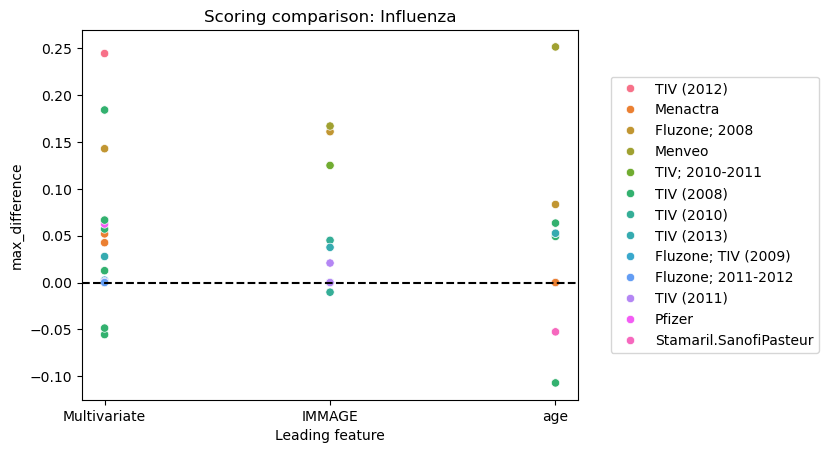

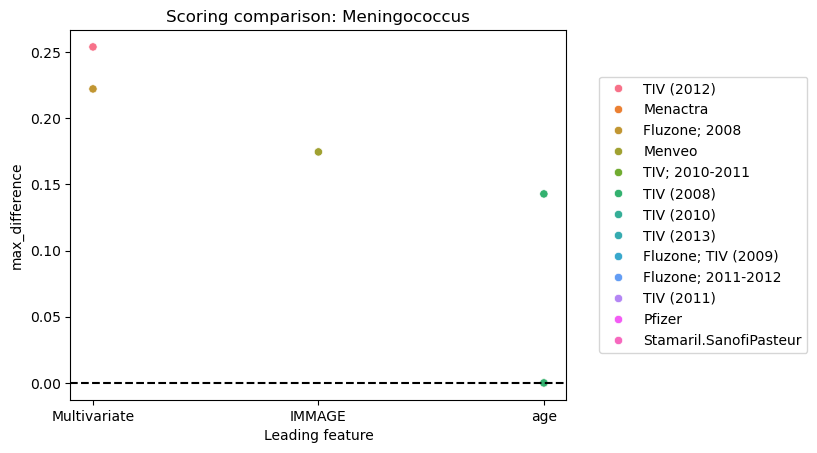

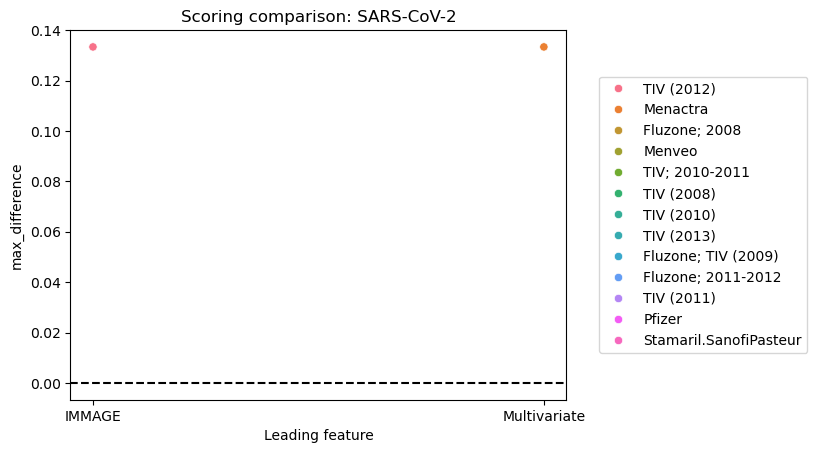

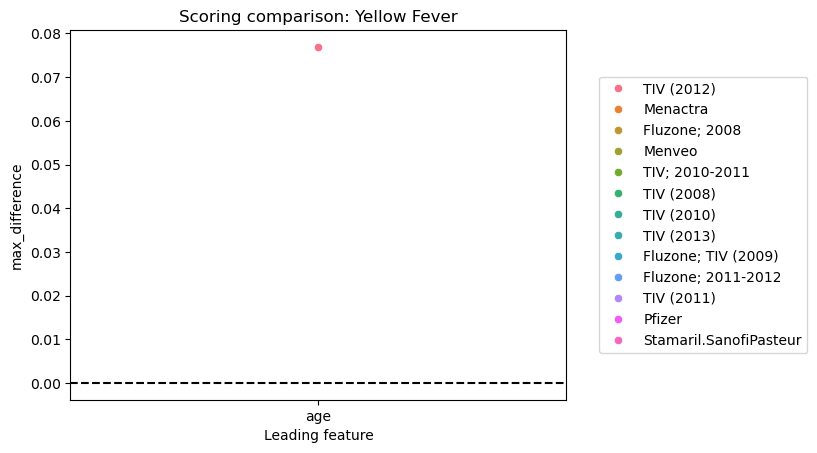

In [88]:
# Plot each virus separately, comparing IMMAGE, multivar and age

def get_leading_feature(row):
    immage_age = row["Composite", "IMMAGE"] - row["Composite", "Age"]
    multivar_age = row["Composite", "Multivariate"] - row["Composite", "Age"]
    if max(immage_age, multivar_age) > 0:
        if immage_age > multivar_age:
            feature = "IMMAGE"
        else :
            feature = "Multivariate"
    else:
        feature = "age"
    return feature

sorted_data["Leading feature"] = results.apply(lambda row: get_leading_feature(row), axis=1)


for virus in sorted_data.Virus.unique():
    data = sorted_data[sorted_data["Virus"] == virus].reset_index()
    scatter = sns.scatterplot(x=data["Leading feature"], y=data["max_difference"], hue=sorted_data[vaccine_col])
    # scatter = sns.scatterplot(x=np.ones(data["immage_contrib"].shape[0])*1, y=data["immage_contrib"], hue=data[vaccine_col])
    # scatter = sns.scatterplot(x=np.ones(data["multivar_contrib"].shape[0])*2, y=data["multivar_contrib"], hue=sorted_data[vaccine_col])
    plt.xticks(rotation=0) 

    # plt.xticks(range(len(sorted_data)), sorted_data[vaccine_col], rotation=45)  # Adjust the rotation angle as needed
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles, labels, loc="center right", bbox_to_anchor=(1.5, 0.5))

    plt.axhline(y=0, color="black", linestyle="--")
    plt.title(f"Scoring comparison: {virus}")
    plt.show()